In [5]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
plt.style.use('seaborn')
%matplotlib notebook

# RK4 routine

In [6]:
def RK4(dydt,tstart,tstop,nt,y0,tspace='log'):
    """
    Function for solving diff. eq of the form dy/dt  = f(t, y) with the Runge Kutta 4 algorithm.
    Non-adaptive stepsize!
    """

    # --- Setup arrays ---
    if tspace == 'log':
        ts = np.logspace(np.log10(tstart),np.log10(tstop),nt)
    elif tspace == 'lin':
        ts = np.linspace(np.log10(tstart),np.log10(tstop),nt)

    dts   = np.diff(ts)
    yvals = np.zeros_like(ts)
    
    # --- Ugly step neccesary because np.diff removes 1 element from ts ---
    yvals = np.delete(yvals,nt-1)
    ts = np.delete(ts,nt-1)
    
    # --- Integrate ----
    yn = y0
    for i,dt in enumerate(dts):
        yvals[i] = yn
        k1 = dt * dydt(ts[i],yvals[i])
        k2 = dt * dydt(ts[i] + dt/2, yvals[i] + k1/2)
        k3 = dt * dydt(ts[i] + dt/2, yvals[i] + k2/2)
        k4 = dt * dydt(ts[i] + dt, yvals[i] + k3)
        yn = yn + k1/6 + k2/3 + k3/3 + k4/6
        
    return ts, yvals

# Evaluer

In [7]:
dadt = lambda t,a: np.sqrt(omega0R * np.power(a,-2) + omega0M * np.power(a,-1) + omega0L * np.power(a,2))

In [8]:
def secondsToHubbletime(seconds):
    """
    Helper function to convert seconds to fractions of Hubble time.
    Returns fraction of Hubble time at (input) seconds
    """
    H0 = 70 * u.km/(u.s * u.Mpc)
    return seconds / (1/H0).to('s').value

In [10]:
# --- Lambda CDM parameters from Ryden ---
omega0R = 8.4e-5
omega0M = 0.3
omega0L = 1. - omega0R - omega0M

# --- Simulation parameters ---
tstart = secondsToHubbletime(1e-3) #start time in Hubble time
tstop  = 1.   #end time in Hubble time
nt    = 10000 #number of timesteps

# --- Run simulation ---
ts, avals = RK4(dadt,tstart=tstart,tstop=1,nt=10000,y0=1e-16)

<IPython.core.display.Javascript object>


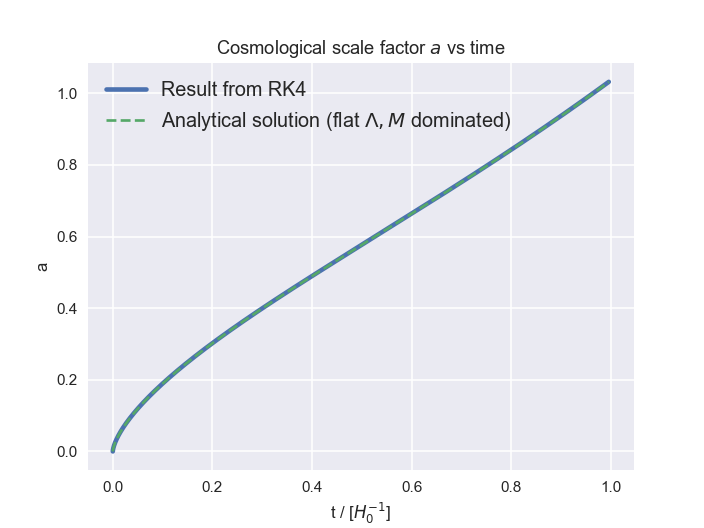

In [11]:
analyticalAs = (np.sinh(3*ts/2 * np.sqrt(omega0L))**2 * omega0M/omega0L)**(1/3)

fig,ax = plt.subplots()
ax.plot(ts,avals,lw=3,label='Result from RK4')
ax.plot(ts,analyticalAs,'--',label=r'Analytical solution (flat $\Lambda, M$ dominated)')
ax.set_xlabel(r't / [$H_0^{-1}$]')
ax.set_ylabel('a')
ax.set_title(r'Cosmological scale factor $a$ vs time')
ax.legend(fontsize=13)

# Growth Equation

$$\ddot{\delta} + 2H\dot{\delta}-(3/2) H^2 \Omega_m \delta =0$$
$$\rightarrow \dot{\delta} = u$$
$$\rightarrow \dot{u} = (3/2) H^2 \Omega_m \delta - 2Hu$$

In [128]:
# --- Calculate H for times ---
dadts = dadt(ts, avals)
Hs    = dadts/avals

In [140]:
def dddt(t, p):
    return p[1]

def dudt(t, p):
    H = Hs[np.argmin((ts-t)**2)]
    return 3/2 * H**2 * omega0M * p[0] - 2*H*p[1]

In [141]:
def RK4(dydts,tstart,tstop,nt,p0,tspace='log'):
    """
    Function for solving diff. eq of the form dy/dt  = f(t, y) with the Runge Kutta 4 algorithm.
    Non-adaptive stepsize!
    """
    nsystems = len(dydts) #Number of dydts aka size of equation system

    # --- Setup arrays ---
    if tspace == 'log':
        ts = np.logspace(np.log10(tstart),np.log10(tstop),nt)
    elif tspace == 'lin':
        ts = np.linspace(tstart,tstop,nt)

    dts   = np.diff(ts)
    yvals = np.zeros((nt,nsystems))
    
    # --- Ugly step neccesary because np.diff removes 1 element from ts ---
    yvals = np.delete(yvals,-1,axis=0)
    ts    = np.delete(ts,-1)
    
    # --- Integrate ----
    yn = p0
    for (i,dt) in enumerate(dts):
        yvals[i] = yn
        for (j,dydt) in enumerate(dydts):
            k1 = dt * dydt(ts[i],yvals[i])
            k2 = dt * dydt(ts[i] + dt/2, yvals[i] + k1/2)
            k3 = dt * dydt(ts[i] + dt/2, yvals[i] + k2/2)
            k4 = dt * dydt(ts[i] + dt, yvals[i] + k3)
            yn[j] = yn[j] + k1/6 + k2/3 + k3/3 + k4/6
    return ts, yvals

In [142]:
ts, vals = RK4([dddt,dudt],tstart=tstart,tstop=1,nt=10000,p0=[0.00001,0])

<ipython-input-140-2cda90dbf49d>:6: RuntimeWarning: overflow encountered in double_scalars
  return 3/2 * H**2 * omega0M * p[0] - 2*H*p[1]
<ipython-input-141-038ca3e7dacd>:27: RuntimeWarning: invalid value encountered in add
  k2 = dt * dydt(ts[i] + dt/2, yvals[i] + k1/2)
<ipython-input-141-038ca3e7dacd>:30: RuntimeWarning: invalid value encountered in double_scalars
  yn[j] = yn[j] + k1/6 + k2/3 + k3/3 + k4/6
